In [1]:
import json
from typing import Generator

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

Load the embeddings. For each entry, we've stored the two sentences and their corresponding embeddings.

In [2]:
def load_jsonl(path: str) -> Generator[dict, None, None]:
    """Load a JSONL file."""
    with open(path, "r") as fin:
        yield from (json.loads(ln) for ln in fin.readlines())


data = list(load_jsonl("data/embeddings.jsonl"))
print(f"Number of error-fixed pairs to test: {len(data)}")

Number of error-fixed pairs to test: 28


Calculate the [cosine similarity][cos] between two embeddings and run it over our pairs.

[cos]: https://en.wikipedia.org/wiki/Cosine_similarity

In [3]:
embeddings = [(entry["emb_err"], entry["emb_fix"]) for entry in data]
similarities = [
    cosine_similarity([err], [emb]).item() for (err, emb) in embeddings
]
print(f"Mean cosine similarity: {np.mean(similarities):.2f}")

Mean cosine similarity: 0.88


Here's the distribution of the similarities for each sentence pair. They're mostly concentrated
at the top end of the score range, `[-1,1]`.

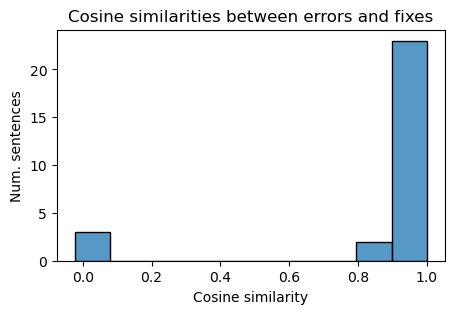

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))
g = sns.histplot(x=similarities, bins=10, ax=ax)
g.set(
    title="Cosine similarities between errors and fixes",
    ylabel="Num. sentences",
    xlabel="Cosine similarity",
)
plt.show()

Which pairs score poorly?

In [5]:
low_scores = [
    idx for idx in range(len(similarities)) if similarities[idx] < 0.5
]
for idx in low_scores:
    err, fix = data[idx]["err"], data[idx]["fix"]
    print(f"Score: {similarities[idx]:0.4f}\n+ {err}\n> {fix}\n")

Score: -0.0015
+ Divorce is tolerated on condition that the husband restore the portion his wife brought him, but is seldom practised, as mu- tual necessities and habits perpetuate the union of the poor; the rich can choose a more com ee plaisant mistress without dismissing the formers Temporary intercourse is rather forbidden by the pride of the sex than by any legal or mordl obligation, it being regarded as a brief mar- viage, and inconstancy as a divorce.
> Divorce is tolerated on condition that the husband restore the portion of his wife brought him, but is seldom practised, as mutual necessities and habits perpetuate the union of the poor; and the rich can choose a more complaisant mistress without dismissing the former. Temporary intercourse is rather forbidding by the pride of the sex than by any legal or moral obligation, it being regarded as a brief marriage, and inconstancy as a divorce.

Score: -0.0230
+ Because the tongne, being full of pores and apnngy, receives great mois

So those are some problems. They're all quite close to 0, which means the embeddings are orthogonal 
to one another (that is, they have no alignment whatsoever). Overall however the concentration of 
scores is promising. It suggests error and fixed sentences are interchangeable.

But that high concentration up at the maximum value for cosine similarity is also grounds for 
suspicion: given how consistently similar embeddings are between sentence pairs, it may be that the 
model isn't making much of a distinction between all sentences in the corpus, fixed or not. That is, 
is any one error sentence interchangeable with any fixed sentence? 

To answer this, we define a function that derives the cosine similarity for each error sentence and 
a randomly selected fixed sentence. That gives us a baseline against which to measure whether an 
error sentence and its actual fixed pair are interchangeable in a way that a random pairing is not. 
We will do this by shuffling/measuring a few hundred times and taking the average of the results.

In [6]:
def shuffle_and_measure(
    errors: list[float], fixes: list[float], k: int = 10, aggregate: bool = True
) -> list[float]:
    """Shuffle fixes randomly against the errors and test their cosine similarities k times."""
    num_obs = len(errors)
    similarities = []
    # For k iterations...
    for _ in range(k):
        rand_sims = []
        # For each error sentence...
        for err in errors:
            # Select a random fixed sentence and find the cosine similarity between the two
            idx = np.random.choice(range(num_obs))
            rand_sims.append(cosine_similarity([err], [fixes[idx]]).item())
        similarities.append(rand_sims)

    # The result from above is a list of k sublists. In the sublists, there are num_obs
    # cosine similiarity scores. We could return them as is...
    if not aggregate:
        return similarities

    # ...or we could aggregate them together, taking the average similarity across k runs for
    # every i-th cosine similarity score (i.e. for every sentence, we get the average cosine
    # similarity score across k random sentence comparisons)
    return [
        np.mean([shuf[i] for shuf in similarities]) for i in range(num_obs)
    ]


errors = [err for (err, _) in embeddings]
fixes = [fix for (_, fix) in embeddings]
shuffled = shuffle_and_measure(errors, fixes, k=250)

Here's the distribution of the original similarities and the ones we've generated above. 
Note the overlap. That's a bad sign...

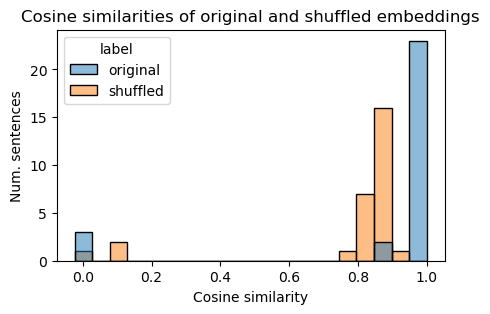

In [7]:
df = pd.DataFrame({"original": similarities, "shuffled": shuffled})
df = df.stack().to_frame(name="value").droplevel(0).reset_index(names="label")

fig, ax = plt.subplots(figsize=(5, 3))
g = sns.histplot(data=df, x="value", bins=20, hue="label", alpha=0.5, ax=ax)
g.set(
    title="Cosine similarities of original and shuffled embeddings",
    ylabel="Num. sentences",
    xlabel="Cosine similarity",
)
plt.show()

To be sure, we'll perform a quick [t-test][test]. Below, we test whether our cosine similarities for
our original pairs and our shuffled pairs have the same average. If they don't, that means we can say 
with confidence that embeddings for an original sentence pair are interchangeable in a way that 
embeddings for a shuffled pair are not.

We'll also define an [effect size][effect] measure, which will give us an sense of the magnitude of 
difference between our embedding groups. As a rule of thumb, 0.2 is a small effect size, 0.5 is medium, 
and 0.8 is large.

Unfortunately, we can't reject our null hypothesis. This means that the model's assignment of embeddings 
to all sentences, error or fixed, isn't specific enough to make a concrete statement about that model's 
ability to "read past" OCR errors. We also see this reflected in the effect size: the amount of 
difference between our embeddings isn't particularly large.

[test]: https://en.wikipedia.org/wiki/Student's_t-test
[effect]: https://en.wikipedia.org/wiki/Effect_size

In [8]:
def cohen_d(A: list[float], B: list[float]) -> float:
    """Calculate Cohen's d (amount of difference between two population means)."""
    return (np.mean(A) - np.mean(B)) / (
        np.sqrt((np.std(A, ddof=1) ** 2 + np.std(B, ddof=1) ** 2) / 2)
    )


alpha = 0.05
test = stats.ttest_ind(shuffled, similarities)
print(
    f"Null hypothesis: randomly shuffled sentence similarities have the same average",
    f"as the original similarities",
    f"\nReject? {test.pvalue < alpha}",
    f"\n+ P value: {test.pvalue:.04f}",
    f"\n+ Effect size: {cohen_d(shuffled, similarities):0.2f}",
)

Null hypothesis: randomly shuffled sentence similarities have the same average as the original similarities 
Reject? False 
+ P value: 0.1462 
+ Effect size: -0.39
